# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

# Импорт библиотек

In [1]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (12, 9)

# Загрузка данных

In [5]:
data = pd.read_excel('geo.xlsx', index_col=0)

In [6]:
data.head()

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


In [7]:
X_coord = data["x"].tolist()
Y_coord = data["y"].tolist()

In [8]:
X = list(map(lambda x, y:[x,y], X_coord, Y_coord))

# Масштабируем данные

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()

In [11]:
X_scaled = scaler.fit_transform(X)

In [12]:
X_scaled

array([[ 0.36791896,  0.15955291],
       [ 0.36791896,  0.15955291],
       [ 0.2931784 , -0.34813064],
       ...,
       [-1.20058354,  1.1836816 ],
       [-0.97563233,  0.38377766],
       [-0.95317246,  1.00936916]])

# Кластеризуем данные безотносительно голосов

In [13]:
from sklearn.cluster import KMeans, DBSCAN

In [14]:
X_scaled[0]

array([0.36791896, 0.15955291])

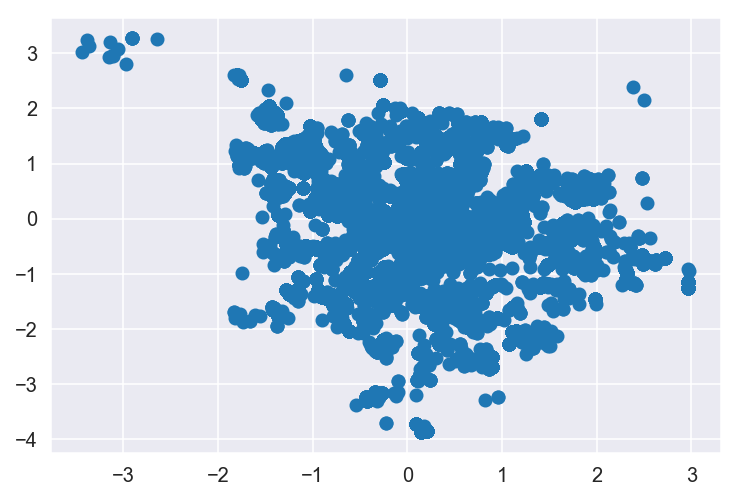

In [15]:
plt.scatter(X_scaled[:,0], X_scaled[:,1])

In [16]:
clf_kmeans = KMeans(n_clusters=12) # попробуем случайно взятое значение
Y = clf_kmeans.fit_predict(X_scaled, )

In [17]:
X_inv = scaler.inverse_transform(X_scaled)

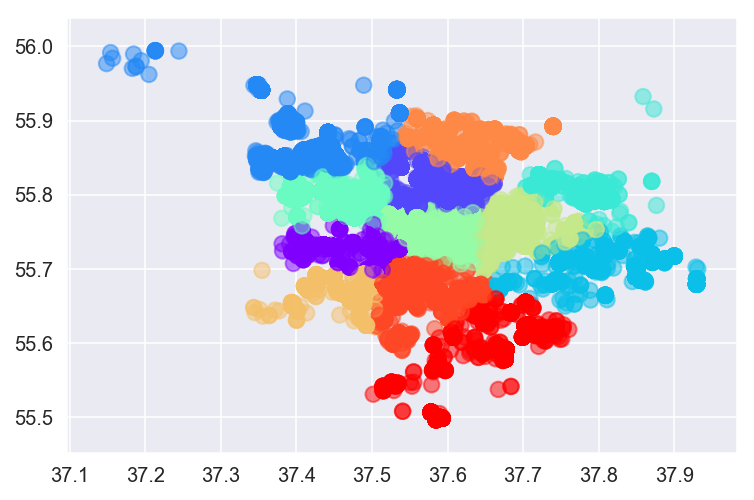

In [18]:
plt.scatter(X_inv[:, 0], X_inv[:, 1], c=Y, cmap='rainbow', s=60, alpha=0.5)

# Подбор количества кластеров для KMeans

In [19]:
k_inertia = []
ks = range(1,20)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X_scaled, )
    k_inertia.append(clf_kmeans.inertia_)

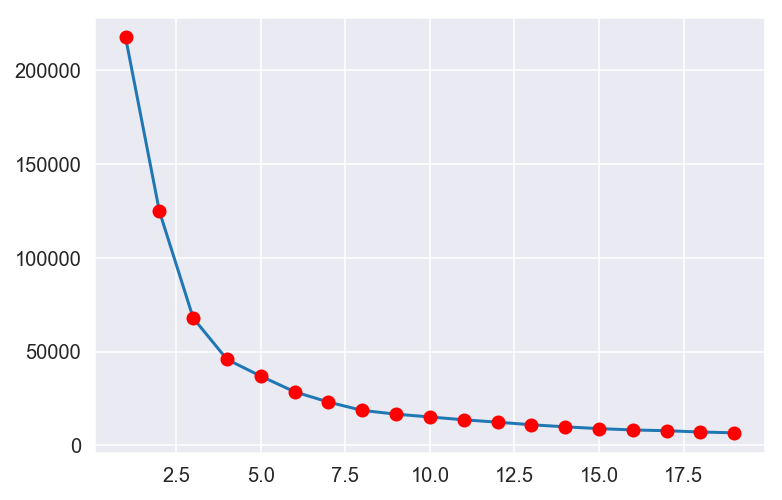

In [20]:
plt.plot(ks, k_inertia)
plt.plot(ks, k_inertia ,'ro')

In [21]:
diff = np.diff(k_inertia)

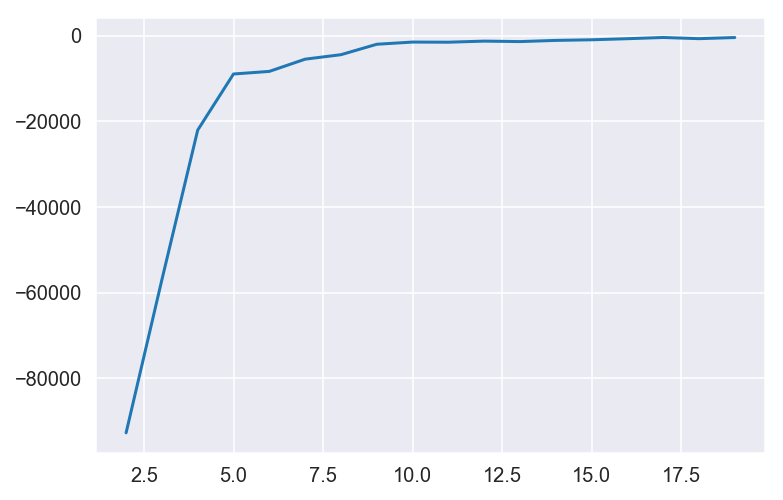

In [22]:
plt.plot(ks[1:], diff)

In [23]:
diff_r = diff[1:] / diff[:-1]

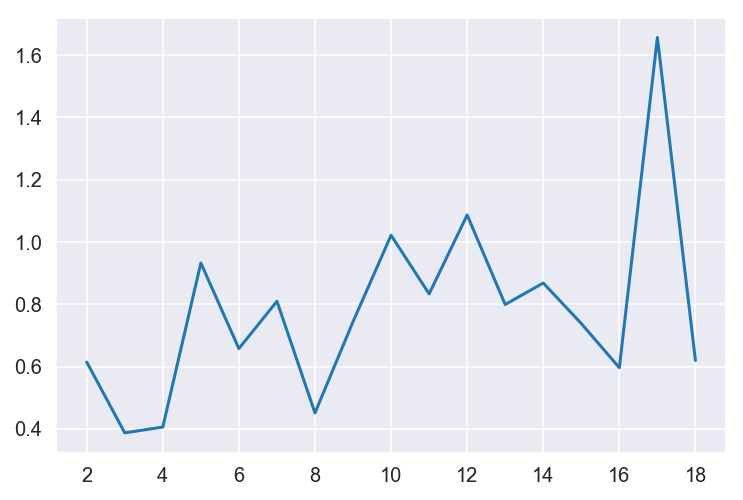

In [24]:
plt.plot(ks[1:-1], diff_r)

In [25]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

3

## Разбиение на 13 кластеров

In [26]:
clf_kmeans = KMeans(n_clusters=13)
Y = clf_kmeans.fit_predict(X_scaled, )

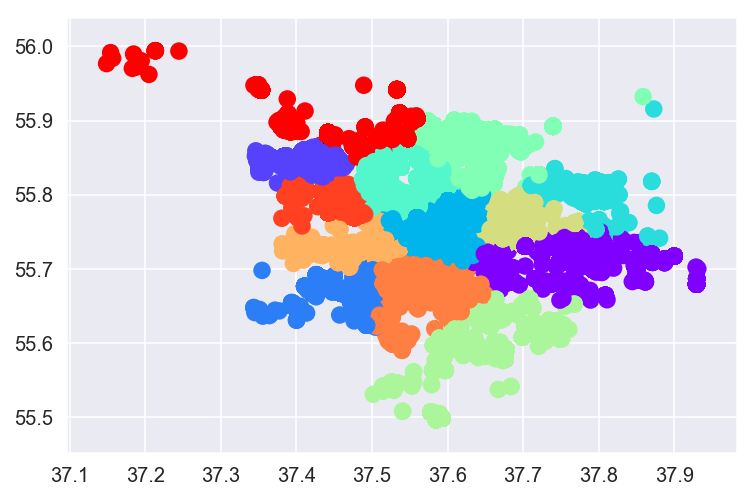

In [27]:
plt.scatter(X_inv[:, 0], X_inv[:, 1], c=Y, cmap='rainbow', s=60, alpha=1)

## Кластеризуем данные по голосам "за" и "против"

In [28]:
comment_class = data["comment_class"].tolist()

In [29]:
pos_comments_scaled = []
neg_comments_scaled = []
for index, comment in enumerate(comment_class):
    if comment == -1:
        neg_comments_scaled.append(X_scaled[index])
    elif comment == 1:
        pos_comments_scaled.append(X_scaled[index])

In [30]:
clf_kmeans_pos = KMeans(n_clusters=13)
clf_kmeans_neg = KMeans(n_clusters=13)
Y_pos = clf_kmeans.fit_predict(pos_comments_scaled, )
Y_neg = clf_kmeans.fit_predict(neg_comments_scaled, )

In [31]:
X_pos_inv = scaler.inverse_transform(pos_comments_scaled)
X_neg_inv = scaler.inverse_transform(neg_comments_scaled)

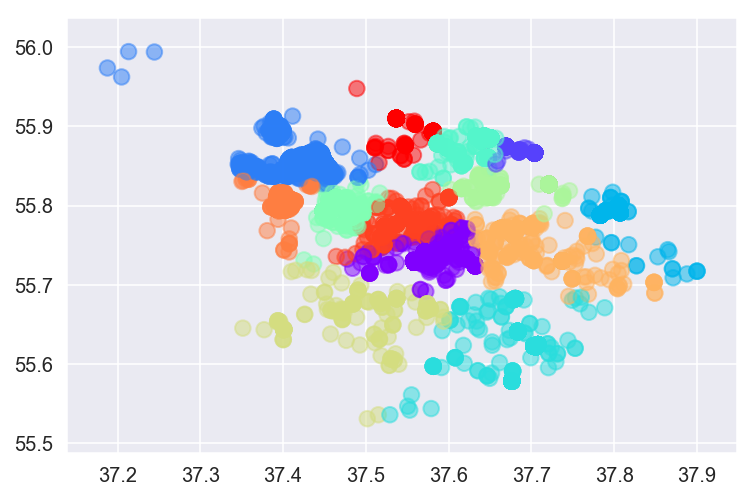

In [32]:
plt.scatter(X_pos_inv[:, 0], X_pos_inv[:, 1], c=Y_pos, cmap='rainbow', s=60, alpha=0.5)
#plt.scatter(X_neg_inv[:, 0], X_neg_inv[:, 1], c=Y_neg, cmap='gray', s=60, alpha=0.5)

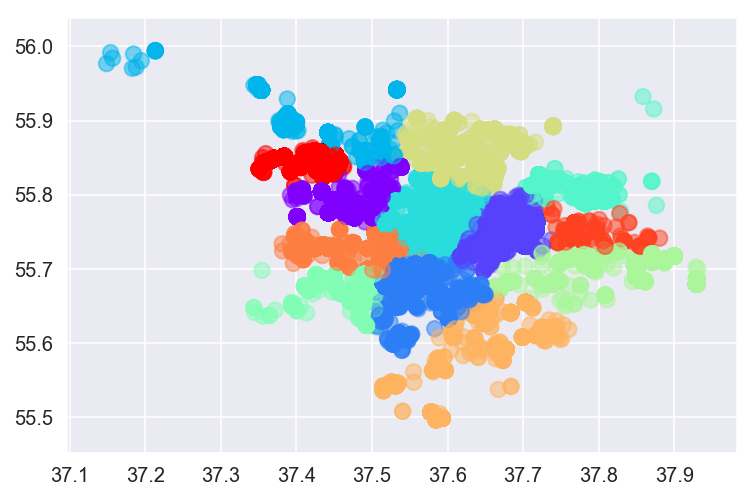

In [33]:
plt.scatter(X_neg_inv[:, 0], X_neg_inv[:, 1], c=Y_neg, cmap='rainbow', s=60, alpha=0.5)

Алгоритм KMeans примерно одинаково кластеризует точки, как относительно, так и безотносительно характера голосов. Оптимальное количество кластеров - 13.